In [2]:
#####Bayesian Tucker Decomposition#####
import numpy as np
import pandas as pd
import matplotlib.pyplot  as plt
import numpy.matlib
import scipy.linalg
import itertools
import seaborn as sns
import gc
from scipy import sparse
from scipy.stats import norm
from pandas.tools.plotting import scatter_matrix
from numpy.random import *
from scipy import optimize

#np.random.seed(98537)

In [3]:
##多項分布の乱数を生成する関数
def rmnom(pr, n, k, no, pattern):
    z_id = np.argmax((np.cumsum(pr, axis=1) >= np.random.uniform(0, 1, n)[:, np.newaxis]), axis=1)
    return z_id
    if pattern==1:
        Z = sparse.coo_matrix((np.repeat(1, n), (no, np.array(z_id))), shape=(n, k))   #スパース行列の設定
        return z_id, Z

In [4]:
####データの発生####
##データの設定
type_n = 3
k1 = 12
k2 = 10
k3 = 7
hh = 5000   #ユーザー数
item = 3000   #アイテム数
context = 100   #コンテキスト数
Lambda = np.random.gamma(35.0, 1/0.2, hh)
pt = np.random.poisson(Lambda, hh)   #ユーザーあたりのレコード数
hhpt = np.sum(pt)
vec_k1 = np.repeat(1, k1); vec_k2 = np.repeat(1, k2); vec_k3 = np.repeat(1, k3)

In [5]:
##IDとインデックスを作成
#IDの作成
user_id = np.repeat(np.arange(hh), pt)
pt_id = np.array(list(itertools.chain(*[np.array(range(pt[i]), dtype="int") for i in range(hh)])))

#インデックスの設定
index = np.array(range(hhpt))
user_list = [i for i in range(hh)]
for i in range(hh):
    user_list[i] = index[user_id==i]
user_dt = sparse.coo_matrix((np.repeat(1, hhpt), (user_id, range(hhpt))), shape=(hh, hhpt)).tocsr()   #スパース行列の設定

In [6]:
##アイテムの割当を生成
#トピック割当を生成
topic = 25
phi_item = np.random.dirichlet(np.repeat(0.5, item), topic)
theta_item = np.random.dirichlet(np.repeat(0.5, topic), hh)
z = np.dot(np.array([np.random.multinomial(1, theta_item[i, :], 1) for i in range(hh)]).reshape(hh, topic), range(topic))

#多項分布からアイテムを生成
item_id = np.zeros(hhpt, dtype='int')
for i in range(hh):
    if i%1000==0:
        print(i)
    item_id[user_list[i]] = np.dot(np.random.multinomial(1, phi_item[z[i], :], pt[i]), range(item))
item_dt = sparse.coo_matrix((np.repeat(1, hhpt), (item_id, range(hhpt))), shape=(item, hhpt)).tocsr()   #スパース行列の設定
item_n = np.array(np.sum(item_dt, axis=1)).reshape(-1)

#アイテムのインデックス
item_list = [i for i in range(item)]
for i in range(item):
    item_list[i] = np.array(np.where(item_id==i)[0], dtype="int")

0
1000
2000
3000
4000


In [7]:
##コンテキストの割当を生成
#トピック割当を生成
topic = 15
phi_context = np.random.dirichlet(np.repeat(0.25, context), topic)
theta_context = np.random.dirichlet(np.repeat(0.25, topic), hh)
z = np.dot(np.array([np.random.multinomial(1, theta_context[i, :], 1) for i in range(hh)]).reshape(hh, topic), range(topic))

#多項分布からアイテムを生成
context_id = np.zeros(hhpt, dtype='int')
for i in range(hh):
    if i%1000==0:
        print(i)
    context_id[user_list[i]] = np.dot(np.random.multinomial(1, phi_context[z[i], :], pt[i]), range(context))
context_dt = sparse.coo_matrix((np.repeat(1, hhpt), (context_id, range(hhpt))), shape=(context, hhpt)).tocsr()   #スパース行列の設定
context_n = np.array(np.sum(context_dt, axis=1)).reshape(-1)

#コンテキストのインデックス
context_list = [i for i in range(context)]
for i in range(context):
    context_list[i] = np.array(np.where(context_id==i)[0], dtype="int")

0
1000
2000
3000
4000


In [8]:
##階層モデルの説明変数を生成
#ユーザーの説明変数を生成
k11 = 3; k12 = 5; k13 = 5
u1 = np.array(np.random.random(hh*k11)).reshape((hh, k11))
u2 = np.zeros((hh, k12))
for j in range(k12):
    prob = np.random.uniform(0.25, 0.55, 1)
    u2[:, j] = np.random.binomial(1, prob, hh)
u3 = np.random.multinomial(1, np.random.dirichlet(np.repeat(3.0, k13), 1).reshape(k13), hh)
u3 = np.delete(u3, np.argmin(np.sum(u3, axis=0)), axis=1)   #冗長な変数の削除
u = np.array(np.concatenate((np.repeat(1, hh)[:, np.newaxis], u1, u2, u3), axis=1), dtype="float32")
col_u = u.shape[1]

#アイテムの説明変数を生成
k21 = 4; k22 = 5; k23 = 4
v1 = np.array(np.random.random(item*k21)).reshape((item, k21))
v2 = np.zeros((item, k22))
for j in range(k22):
    prob = np.random.uniform(0.25, 0.55, 1)
    v2[:, j] = np.random.binomial(1, prob, item)
v3 = np.random.multinomial(1, np.random.dirichlet(np.repeat(3.0, k23), 1).reshape(k23), item)
v3 = np.delete(v3, np.argmin(np.sum(v3, axis=0)), axis=1)   #冗長な変数の削除
v = np.array(np.concatenate((np.repeat(1, item)[:, np.newaxis], v1, v2, v3), axis=1), dtype="float32")
col_v = v.shape[1]

In [9]:
##応答変数を生成
per_min = 75; per_max = 75
rp = 0
while True:
    rp = rp + 1

    ##パラメータを生成
    #階層モデルの回帰係数を生成
    alpha1 = np.random.normal(0, 0.4, col_u)
    alpha2 = np.random.normal(0, 0.4, col_v)
    alpha_u = np.random.normal(0, 0.3, col_u*k1).reshape(col_u, k1)
    alpha_v = np.random.normal(0, 0.3, col_u*k2).reshape(col_v, k2)
    alphat1 = alpha1.copy(); alphat2 = alpha2.copy(); alphat_u = alpha_u.copy(); alphat_v = alpha_v.copy()

    #階層モデルの分散を生成
    tau1 = np.array([0.5])
    tau2 = np.array([0.5])
    Cov_u = np.diag(np.repeat(0.1, k1))
    Cov_v = np.diag(np.repeat(0.1, k2))
    taut1 = tau1.copy(); taut2 = tau2.copy(); Covt_u = Cov_u.copy(); Covt_v = Cov_v.copy()

    #モデルパラメータを生成
    Sigma = np.array([1.0])
    beta = np.array([-1.0])
    beta1 = np.dot(u, alpha1) + np.random.normal(0, tau1, hh)
    beta2 = np.dot(v, alpha2) + np.random.normal(0, tau2, item)
    theta_u = np.dot(u, alpha_u) + np.random.multivariate_normal(np.repeat(0, k1), Cov_u, hh)
    theta_v = np.dot(v, alpha_v) + np.random.multivariate_normal(np.repeat(0, k2), Cov_v, item)
    theta_c = np.random.multivariate_normal(np.repeat(0, k3), np.diag(np.repeat(0.2, k3)), context)
    omega = np.random.normal(0, 0.25, k1*k2*k3).reshape(k1, k2, k3)
    betat= beta.copy(); betat1 = beta1.copy(); betat2 = beta2.copy()
    thetat_u = theta_u.copy(); thetat_v = theta_v.copy(); thetat_c = theta_c.copy(); omegat = omega.copy()

    ##正規分布から応答変数を生成
    #タッカー分解の期待値
    uv = np.repeat(0.0, hhpt)
    theta_vec2 = theta_v[item_id, ]
    theta_vec3 = theta_c[context_id, ]
    for j in range(k3):
        uv += np.dot(np.dot(theta_u, omega[:, :, j])[user_id, ] * theta_vec2 * theta_vec3[:, j][:, np.newaxis], vec_k2)
    mu = beta + beta1[user_id] + beta2[item_id] + uv

    #潜在効用から二値変数を生成
    U = np.random.normal(mu, Sigma, hhpt); UT = U.copy()
    y = (U >= 0)*1 + (U < 0)*0   #購買有無に変換
    Prob = norm.cdf(mu, 0, Sigma)
    Prob[Prob==1.0] = 0.9999999999; Prob[Prob==0] = np.power(10.0, -100)

    #break条件
    print([rp, np.sum(U < -7.5), np.sum(U > 7.5), np.round(np.mean(y), 3)])
    if (np.mean(y) > 0.2) & (np.mean(y) < 0.4) & (np.sum(U <= -7.5) < hhpt/per_min) & (np.sum(U > 7.5) < hhpt/per_max):
        break

[1, 11537, 65, 0.11]
[2, 1065, 652, 0.514]
[3, 2198, 2507, 0.456]
[4, 1718, 2229, 0.456]
[5, 114, 711, 0.499]
[6, 857, 1339, 0.442]
[7, 1194, 366, 0.302]


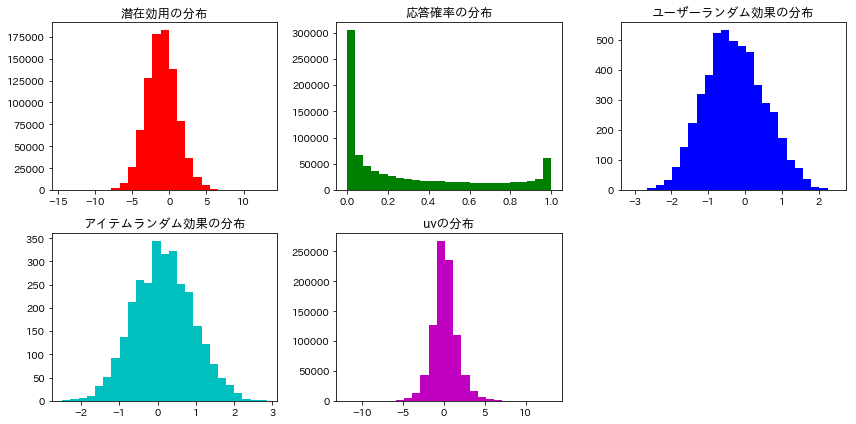

In [10]:
#潜在変数ごとのヒストグラム
dt = [U, Prob, beta1, beta2, uv]
fig_range = np.append(np.array([np.min(U), 0, np.min(beta1), np.min(beta2), np.min(uv)]), 
                      np.array([np.max(U), 1.0, np.max(beta1), np.max(beta2), np.max(uv)])).reshape(2, len(dt))
colorlist = ["r", "g", "b", "c", "m", "y", "k", "w"]
legend = ["潜在効用の分布", "応答確率の分布", "ユーザーランダム効果の分布", "アイテムランダム効果の分布", "uvの分布"]
fig = plt.figure(figsize=(12.0, 6.0))
for j in range(len(dt)):
    ax = fig.add_subplot(2, 3, j+1)
    ax.hist(dt[j],  bins=25, range=(fig_range[0, j], fig_range[1, j]), color=colorlist[j])
    plt.title(legend[j], fontsize=12.5)
fig.tight_layout()
plt.show()

In [11]:
####テストデータを生成####
##データの設定
division = 2
pt0 = np.random.poisson(Lambda / division, hh)
pt0[pt0 < 5] = 5
N = np.sum(pt0)

In [12]:
##IDとインデックスを作成
#IDの作成
user_id0 = np.repeat(np.arange(hh), pt0)
pt_id0 = np.array(list(itertools.chain(*[np.array(range(pt0[i]), dtype="int") for i in range(hh)])))

#インデックスの設定
index = np.array(range(N))
user_list0 = [i for i in range(hh)]
for i in range(hh):
    user_list0[i] = index[user_id0==i]
user_dt0 = sparse.coo_matrix((np.repeat(1, N), (user_id0, range(N))), shape=(hh, N)).tocsr()   #スパース行列の設定

In [13]:
##アイテムの割当を生成
#トピック割当を生成
topic = 25
z = np.dot(np.array([np.random.multinomial(1, theta_item[i, :], 1) for i in range(hh)]).reshape(hh, topic), range(topic))

#多項分布からアイテムを生成
item_id0 = np.zeros(N, dtype='int')
for i in range(hh):
    if i%1000==0:
        print(i)
    item_id0[user_list0[i]] = np.dot(np.random.multinomial(1, phi_item[z[i], :], pt0[i]), range(item))
item_dt0 = sparse.coo_matrix((np.repeat(1, N), (item_id0, range(N))), shape=(item, N)).tocsr()   #スパース行列の設定
item_n0 = np.array(np.sum(item_dt0, axis=1)).reshape(-1)

0
1000
2000
3000
4000


In [14]:
##コンテキストの割当を生成
#トピック割当を生成
topic = 15
z = np.dot(np.array([np.random.multinomial(1, theta_context[i, :], 1) for i in range(hh)]).reshape(hh, topic), range(topic))

#多項分布からアイテムを生成
context_id0 = np.zeros(N, dtype='int')
for i in range(hh):
    if i%1000==0:
        print(i)
    context_id0[user_list0[i]] = np.dot(np.random.multinomial(1, phi_context[z[i], :], pt0[i]), range(context))
context_dt0 = sparse.coo_matrix((np.repeat(1, N), (context_id0, range(N))), shape=(context, N)).tocsr()   #スパース行列の設定
context_n0 = np.array(np.sum(context_dt0, axis=1)).reshape(-1)

0
1000
2000
3000
4000


In [15]:
##正規分布から応答変数を生成
#タッカー分解の期待値
uv0 = np.repeat(0.0, N)
theta_vec2 = theta_v[item_id0, ]
theta_vec3 = theta_c[context_id0, ]
for j in range(k3):
    uv0 += np.dot(np.dot(theta_u, omega[:, :, j])[user_id0, ] * theta_vec2 * theta_vec3[:, j][:, np.newaxis], vec_k2)
mu0 = beta + beta1[user_id0] + beta2[item_id0] + uv0

#潜在効用から二値変数を生成
U0 = np.random.normal(mu0, Sigma, N); UT0 = U0.copy()
y0 = (U0 >= 0)*1 + (U0 < 0)*0   #購買有無に変換

In [16]:
####Bayesian Tucker Decompositionを推定####
##切断正規分布の乱数を発生させる関数
def rtnorm(mu, sigma, a, b, n):
    FA = norm.cdf(a, mu, sigma)
    FB = norm.cdf(b, mu, sigma)
    return norm.ppf(np.random.uniform(0, 1, n)*(FB-FA)+FA, mu, sigma)

In [17]:
##ベイジアン多変量回帰モデルをギブスサンプリングする関数
def rmultireg(Y, X, inv_XXV, XY, Cov, ADelta, Deltabar, V, nu, n, col, k):
    #事後分布のパラメータを設定
    beta_mu = np.dot(inv_XXV, XY + np.dot(ADelta, Deltabar)).T.reshape(-1)   #平均ベクトル
    sigma = np.kron(Cov, inv_XXV)   #分散共分散行列

    #パラメータをサンプリング
    beta_vec = np.random.multivariate_normal(beta_mu, sigma, 1)
    beta = beta_vec.reshape(col, k, order='F')   #回帰行列に変換

    
    ##逆ウィシャート分布から分散共分散行列をサンプリング
    #モデル誤差を設定
    mu = np.dot(X, beta)
    er = Y - mu

    #逆ウィシャート分布のパラメータ
    IW_R = np.dot(er.T, er) + V
    Sn = n + nu

    #パラメータをサンプリング
    Cov = scipy.stats.invwishart.rvs(Sn, IW_R, 1)
    return beta, Cov

In [18]:
##アルゴリズムの設定
k = 10
R = 2000
keep = 2
burnin = int(100/keep)
iter = 0
disp = 10

In [19]:
##事前分布の設定
#階層モデルの事前分布
delta = np.repeat(0, k)
ADelta_u = np.diag(np.repeat(0.1, col_u))
Deltabar_u = np.full((col_u, k1+1), 0.0)
ADelta_v = np.diag(np.repeat(0.1, col_v))
Deltabar_v = np.full((col_v, k2+1), 0.0)
V1 = 0.1 * np.diag(np.ones(k1+1))
V2 = 0.1 * np.diag(np.ones(k2+1))
nu = 1
s01 = 0.1
s01 = 0.1

#モデルパラメータの事前分布
alpha_c = np.repeat(0.0, k3)
inv_Cov_c = np.diag(np.repeat(10.0, k3))
alpha_g = np.repeat(0.0, k1*k2)
inv_Cov_g = np.diag(np.repeat(10.0, k1*k2))
tau = 100 
s02 = 1.0
v02 = 1.0

In [20]:
##パラメータの真値
#階層モデルの回帰係数の真値
alpha1 = np.array(alphat1, dtype="float32")
alpha2 = np.array(alphat2, dtype="float32")
alpha_u = np.array(alphat_u, dtype="float32")
alpha_v = np.array(alphat_v, dtype="float32")
u_mu = np.dot(u, np.hstack((alpha1[:, np.newaxis], alpha_u)))
v_mu = np.dot(v, np.hstack((alpha2[:, np.newaxis], alpha_v)))

#階層モデルの分散の真値
tau1 = np.array(taut1, dtype="float32")
tau2 = np.array(taut2, dtype="float32")
Cov_u = np.array(Covt_u, dtype="float32")
Cov_v = np.array(Covt_v, dtype="float32")
inv_Cov_u = np.linalg.inv(Cov_u)
inv_Cov_v = np.linalg.inv(Cov_v)

#モデルパラメータの真値
Sigma = np.array([1.0], dtype="float32")
beta = np.array(betat, dtype="float32")
beta1 = np.array(betat1, dtype="float32")
beta2 = np.array(betat2, dtype="float32")
theta_u = np.array(thetat_u, dtype="float32")
theta_v = np.array(thetat_v, dtype="float32")
theta_c = np.array(thetat_c, dtype="float32")
omega = np.array(omegat, dtype="float32")

#タッカー分解の期待値
uv = np.array(np.repeat(0.0, hhpt), dtype="float32")
beta_vec1 = beta1[user_id]; beta_vec2 = beta2[item_id]
theta_vec2 = theta_v[item_id, ]; theta_vec3 = theta_c[context_id, ]
for j in range(k3):
    uv += np.dot(np.dot(theta_u, omega[:, :, j])[user_id, ] * theta_vec2 * theta_vec3[:, j][:, np.newaxis], vec_k2)
mu = beta + beta_vec1 + beta_vec2 + uv

In [21]:
##初期値の設定
#階層モデルの回帰係数の初期値
alpha1 = np.array(np.random.normal(0, 0.1, col_u), dtype="float32")
alpha2 = np.array(np.random.normal(0, 0.1, col_v), dtype="float32")
alpha_u = np.array(np.random.normal(0, 0.1, col_u*k1).reshape(col_u, k1), dtype="float32")
alpha_v = np.array(np.random.normal(0, 0.1, col_v*k2).reshape(col_v, k2), dtype="float32")
u_mu = np.dot(u, np.hstack((alpha1[:, np.newaxis], alpha_u)))
v_mu = np.dot(v, np.hstack((alpha2[:, np.newaxis], alpha_v)))

#階層モデルの分散の初期値
tau1 = np.array([0.1], dtype="float32")
tau2 = np.array([0.1], dtype="float32")
Cov_u = np.array(np.diag(np.repeat(0.1, k1)), dtype="float32")
Cov_v = np.array(np.diag(np.repeat(0.1, k2)), dtype="float32")
inv_Cov_u = np.linalg.inv(Cov_u)
inv_Cov_v = np.linalg.inv(Cov_v)

#モデルパラメータの初期値
Sigma = np.array([1.0], dtype="float32") 
beta = np.array([-0.5], dtype="float32")
beta1 = np.array(np.random.normal(0, 0.1, hh), dtype="float32")
beta2 = np.array(np.random.normal(0, 0.1, item), dtype="float32")
theta_u = np.array(np.random.multivariate_normal(np.repeat(0.0, k1), np.diag(np.repeat(0.01, k1)), hh), dtype="float32")
theta_v = np.array(np.random.multivariate_normal(np.repeat(0.0, k2), np.diag(np.repeat(0.01, k2)), item), dtype="float32")
theta_c = np.array(np.random.multivariate_normal(np.repeat(0.0, k3), np.diag(np.repeat(0.01, k3)), context), dtype="float32")
omega = np.array(np.random.normal(0, 0.01, k1*k2*k3).reshape(k1, k2, k3), dtype="float32")

#タッカー分解の期待値
uv = np.array(np.repeat(0.0, hhpt), dtype="float32")
beta_vec1 = beta1[user_id]; beta_vec2 = beta2[item_id]
theta_vec2 = theta_v[item_id, ]; theta_vec3 = theta_c[context_id, ]
for j in range(k3):
    uv += np.dot(np.dot(theta_u, omega[:, :, j])[user_id, ] * theta_vec2 * theta_vec3[:, j][:, np.newaxis], vec_k2)
mu = beta + beta_vec1 + beta_vec2 + uv

In [22]:
##データの設定
#切断領域を定義
rho = 7.5
a = np.array((1-y)*(-rho) + y*0, dtype="float32")
b = np.array(y*rho + (1-y)*0, dtype="float32")
flag =  y - (1-y)

#データの定数を定義
intercept = np.array(np.repeat(1, hhpt), dtype="float32")[:, np.newaxis]
uu = np.dot(u.T, u)
inv_uu = np.linalg.inv(uu)
vv = np.dot(v.T, v)
inv_vv = np.linalg.inv(vv)

#特徴行列の割当インデックス
allocation_u = np.repeat(np.arange(k1), k2)
allocation_v = np.tile(np.arange(k2), k1)
allocation_omega = np.array([np.delete(np.arange(k3), j).tolist() for j in range(k3)])

In [24]:
allocation_omega

array([[1, 2, 3, 4, 5, 6],
       [0, 2, 3, 4, 5, 6],
       [0, 1, 3, 4, 5, 6],
       [0, 1, 2, 4, 5, 6],
       [0, 1, 2, 3, 5, 6],
       [0, 1, 2, 3, 4, 6],
       [0, 1, 2, 3, 4, 5]])

In [22]:
##対数尤度の基準値
#学習データに対する1パラメータモデルの対数尤度
LLst = np.sum(y*np.log(np.mean(y)) + (1-y)*np.log(1-np.mean(y)))
print(LLst)

#学習データに対する真値の対数尤度
uv = np.array(np.repeat(0.0, hhpt), dtype="float32")
theta_vec2 = thetat_v[item_id, ]; theta_vec3 = thetat_c[context_id, ]
for j in range(k3):
    uv += np.dot(np.dot(thetat_u, omegat[:, :, j])[user_id, ] * theta_vec2 * theta_vec3[:, j][:, np.newaxis], vec_k2)
mu = betat + betat1[user_id] + betat2[item_id] + uv
Prob = norm.cdf(mu, 0, Sigma)
Prob[Prob==1.0] = 0.9999999999; Prob[Prob==0] = np.power(10.0, -100)
LLbest = np.sum(y*np.log(Prob)) + np.sum((1-y)*np.log(1-Prob))
print(LLbest)

#学習データに対する1パラメータモデルの対数尤度
LLst0 = np.sum(y0*np.log(np.mean(y)) + (1-y0)*np.log(1-np.mean(y)))
print(LLst0)

#テストデータに対する真値の対数尤度
uv0 = np.array(np.repeat(0.0, N), dtype="float32")
theta_vec02 = thetat_v[item_id0, ]; theta_vec03 = thetat_c[context_id0, ]
for j in range(k3):
    uv0 += np.dot(np.dot(thetat_u, omegat[:, :, j])[user_id0, ] * theta_vec02 * theta_vec03[:, j][:, np.newaxis], vec_k2)
mu0 = betat + betat1[user_id0] + betat2[item_id0] + uv0
Prob0 = norm.cdf(mu0, 0, Sigma)
Prob0[Prob0==1.0] = 0.9999999999; Prob0[Prob0==0] = np.power(10.0, -100)
LLbest0 = np.sum(y0*np.log(Prob0)) + np.sum((1-y0)*np.log(1-Prob0))
print(LLbest0)

-491703.9668722977
-262522.75272625074
-245953.28873716827
-130995.86499670328


In [23]:
####ギブスサンプリングでパラメータをサンプリング####
for rp in range(R):
    
    ##切断正規分布から潜在効用を生成
    #モデルの期待値
    uv = np.array(np.repeat(0.0, hhpt), dtype="float32")
    beta_vec1 = beta1[user_id]; beta_vec2 = beta2[item_id]
    theta_vec2 = theta_v[item_id, ]; theta_vec3 = theta_c[context_id, ]
    for j in range(k3):
        uv += np.dot(np.dot(theta_u, omega[:, :, j])[user_id, ] * theta_vec2 * theta_vec3[:, j][:, np.newaxis], vec_k2)
    mu = beta + beta_vec1 + beta_vec2 + uv
    
    #潜在効用を生成
    U = np.array(rtnorm(mu, Sigma, a, b, hhpt), dtype="float32")

    
    ##モデルの期待値パラメータをサンプリング
    #データの設定
    Sigma_sq = np.power(Sigma, 2)
    er_y = U - beta_vec1 - beta_vec2 - uv

    #正規分布から期待値をサンプリング
    weights = np.power(tau, 2) / (Sigma_sq/hhpt + np.power(tau, 2))
    mu_par = weights * np.mean(er_y)
    beta = np.random.normal(mu_par, weights*Sigma_sq/hhpt, 1) 


    ##ユーザーパラメータをサンプリング
    #モデル誤差を定義
    inv_Cov1 = np.diag(np.append(1/tau1, np.diag(inv_Cov_u)))
    er_y = U - beta - beta_vec2

    #新しい入力変数を生成
    X = np.array(np.zeros((hhpt, k1)), dtype="float32")
    for j in range(k3):
        X += np.dot(theta_v, omega[:, :, j].T)[item_id, ] * theta_vec3[:, j][:, np.newaxis]
    X = np.hstack((intercept, X))

    #多変量正規分布から事後分布をサンプリング
    theta1 = np.zeros((hh, k1+1))
    for i in range(hh):
        x = X[user_list[i], ]
        xy = np.dot(x.T, er_y[user_list[i]])
        xxv = np.dot(x.T, x) + inv_Cov1
        inv_xxv = np.linalg.inv(np.array(xxv, dtype="float64"))
        theta_par = np.dot(inv_xxv, xy + np.dot(inv_Cov1, u_mu[i, ]))
        theta1[i, ] = np.random.multivariate_normal(theta_par, Sigma_sq*inv_xxv, 1)
    beta1 = np.array(theta1[:, 0], dtype="float32")
    theta_u = np.array(theta1[:, 1:], dtype="float32")
    beta_vec1 = beta1[user_id]
    theta_vec1 = theta_u[user_id, ]


    ##アイテムパラメータをサンプリング
    #モデル誤差を定義
    inv_Cov2 = np.diag(np.append(1/tau2, np.diag(inv_Cov_v)))
    er_y = U - beta - beta_vec1

    #新しい入力変数を生成
    X = np.array(np.zeros((hhpt, k2)), dtype="float32")
    for j in range(k3):
        X += np.dot(theta_u, omega[:, :, j])[user_id, ] * theta_vec3[:, j][:, np.newaxis]
    X = np.hstack((intercept, X))

    #多変量正規分布から事後分布をサンプリング
    theta2 = np.zeros((item, k2+1))
    for i in range(item):
        x = X[item_list[i], ]
        xy = np.dot(x.T, er_y[item_list[i]])
        xxv = np.dot(x.T, x) + inv_Cov2
        inv_xxv = np.linalg.inv(np.array(xxv, dtype="float64"))
        theta_par = np.dot(inv_xxv, xy + np.dot(inv_Cov2, v_mu[i, ]))
        theta2[i, ] = np.random.multivariate_normal(theta_par, Sigma_sq*inv_xxv, 1)
    beta2 = np.array(theta2[:, 0], dtype="float32")
    theta_v = np.array(theta2[:, 1:], dtype="float32")
    beta_vec2 = beta2[item_id]
    theta_vec2 = theta_v[item_id, ]


    ##コンテキストパラメータをサンプリング
    #モデル誤差を定義
    er_y = U - beta - beta_vec1 - beta_vec2

    #新しい入力変数を生成
    X = np.array(np.zeros((hhpt, k3)), dtype="float32")
    for j in range(k3):
        X[:, j] = np.dot(np.dot(theta_u, omega[:, :, j])[user_id, ] * theta_vec2, vec_k2)

    #多変量正規分布から事後分布をサンプリング
    for i in range(context):
        x = X[context_list[i], ]
        xy = np.dot(x.T, er_y[context_list[i]])
        xxv = np.dot(x.T, x) + inv_Cov_c
        inv_xxv = np.linalg.inv(np.array(xxv, dtype="float64"))
        theta_par = np.dot(inv_xxv, xy + np.dot(inv_Cov_c, alpha_c))
        theta_c[i, ] = np.random.multivariate_normal(theta_par, Sigma_sq*inv_xxv, 1)


    ##コアテンソルをサンプリング
    #タッカー分解の期待値を展開
    uv_deploy = np.zeros((hhpt, k3), dtype="float32")
    for j in range(k3):
        uv_deploy[:, j] = np.dot(np.dot(theta_u, omega[:, :, j])[user_id, ] * theta_vec2 * theta_vec3[:, j][:, np.newaxis], vec_k2)
    theta_deploy = theta_u[:, allocation_u][user_id, ] * theta_v[:, allocation_v][item_id, ]

    #多変量正規分布から事後分布をサンプリング
    for j in range(k3):
        er_y = U - beta - beta_vec1 - beta_vec2 - np.dot(uv_deploy[:, allocation_omega[j, ]], np.repeat(1, k3-1))   #モデル誤差
        x = theta_deploy * theta_vec3[:, j][:, np.newaxis]
        xy = np.dot(x.T, er_y)
        xxv = np.dot(x.T, x) + inv_Cov_g
        inv_xxv = np.linalg.inv(xxv)
        omega_par = np.dot(inv_xxv, xy + np.dot(inv_Cov_g, alpha_g))
        omega[: ,: , j] = np.random.multivariate_normal(omega_par, Sigma_sq*inv_xxv, 1).reshape(k1, k2)
        uv_deploy[:, j] = np.dot(np.dot(theta_u, omega[:, :, j])[user_id, ] * theta_vec2 * theta_vec3[:, j][:, np.newaxis], vec_k2)


    ##階層モデルのパラメータをサンプリング
    #多変量回帰モデルからユーザーパラメータをサンプリング
    Cov1 = np.linalg.inv(inv_Cov1)
    out = rmultireg(theta1, u, inv_uu, np.dot(u.T, theta1), Cov1, ADelta_u, Deltabar_u, V1, nu, hh, col_u, k1+1)
    alpha1 = np.array(out[0][:, 0], dtype="float32"); alpha_u = np.array(out[0][:, 1:], dtype="float32")
    tau1 = np.array(out[1][0, 0], dtype="float32"); Cov_u = np.array(np.diag(np.diag(out[1])[1:]), dtype="float32")
    u_mu = np.dot(u, np.hstack((alpha1[:, np.newaxis], alpha_u)))
    inv_Cov_u = np.linalg.inv(Cov_u)

    #多変量回帰モデルからアイテムパラメータをサンプリング
    Cov2 = np.linalg.inv(inv_Cov2)
    out = rmultireg(theta2, v, inv_vv, np.dot(v.T, theta2), Cov2, ADelta_v, Deltabar_v, V2, nu, item, col_v, k2+1)
    alpha2 = np.array(out[0][:, 0], dtype="float32"); alpha_v = np.array(out[0][:, 1:], dtype="float32")
    tau2 = np.array(out[1][0, 0], dtype="float32"); Cov_v = np.array(np.diag(np.diag(out[1])[1:]), dtype="float32")
    v_mu = np.dot(v, np.hstack((alpha2[:, np.newaxis], alpha_v)))
    inv_Cov_v = np.linalg.inv(Cov_v)
    
    
    ##サンプリング結果の格納と表示
    if rp%keep==0:
        #サンプリング結果の格納
        mkeep = int(rp/keep)

    #サンプリング結果の表示
    if rp%disp==0:
        #学習データに対する対数尤度を更新
        mu = beta + beta_vec1 + beta_vec2 + np.dot(uv_deploy, vec_k3)
        Prob = norm.cdf(mu, 0, Sigma)
        Prob[Prob==1.0] = 0.9999999999; Prob[Prob==0] = np.power(10.0, -100)
        LL = np.sum(y*np.log(Prob)) + np.sum((1-y)*np.log(1-Prob))

        #テストデータに対する対数尤度を更新
        uv0 = np.array(np.repeat(0.0, N), dtype="float32")
        theta_vec02 = theta_v[item_id0, ]; theta_vec03 = theta_c[context_id0, ]
        for j in range(k3):
            uv0 += np.dot(np.dot(theta_u, omega[:, :, j])[user_id0, ] * theta_vec02 * theta_vec03[:, j][:, np.newaxis], vec_k2)
        mu0 = beta + beta1[user_id0] + beta2[item_id0] + uv0
        Prob0 = norm.cdf(mu0, 0, Sigma)
        Prob0[Prob0==1.0] = 0.9999999999; Prob0[Prob0==0] = np.power(10.0, -100)
        LL0 = np.sum(y0*np.log(Prob0)) + np.sum((1-y0)*np.log(1-Prob0))

        #サンプリング結果の表示
        print(rp)
        print([np.round(LL, 1), np.round(LLbest, 1), np.round(LLst, 1)])
        print([np.round(LL0, 1), np.round(LLbest0, 1), np.round(LLst0, 1)])

0
[-433490.7, -262522.8, -491704.0]
[-223575.9, -130995.9, -245953.3]
10
[-310588.3, -262522.8, -491704.0]
[-171626.2, -130995.9, -245953.3]
20
[-283025.1, -262522.8, -491704.0]
[-165225.4, -130995.9, -245953.3]
30
[-273140.6, -262522.8, -491704.0]
[-164897.0, -130995.9, -245953.3]
40
[-269253.7, -262522.8, -491704.0]
[-165796.4, -130995.9, -245953.3]
50
[-267198.1, -262522.8, -491704.0]
[-166301.5, -130995.9, -245953.3]
60
[-265833.1, -262522.8, -491704.0]
[-166745.1, -130995.9, -245953.3]
70
[-265995.6, -262522.8, -491704.0]
[-166205.3, -130995.9, -245953.3]
80
[-265446.7, -262522.8, -491704.0]
[-166682.4, -130995.9, -245953.3]
90
[-265301.9, -262522.8, -491704.0]
[-166710.2, -130995.9, -245953.3]
100
[-265399.1, -262522.8, -491704.0]
[-166632.3, -130995.9, -245953.3]
110
[-265583.5, -262522.8, -491704.0]
[-166342.5, -130995.9, -245953.3]
120
[-265524.1, -262522.8, -491704.0]
[-166483.9, -130995.9, -245953.3]


KeyboardInterrupt: 

In [ ]:
uv_deploy = np.zeros((hhpt, k3), dtype="float32")
for j in range(k3):
    uv_deploy[:, j] = np.dot(np.dot(theta_u, omega[:, :, j])[user_id, ] * theta_vec2 * theta_vec3[:, j][:, np.newaxis], vec_k2)
theta_deploy = theta_u[:, allocation_u][user_id, ] * theta_v[:, allocation_v][item_id, ]

In [25]:
e

(870499, 7)